In [1]:
import torch
import torch.nn as nn
from torch.optim.lr_scheduler import StepLR
import torch.optim as optim
from model import Unet_Generator, Discriminator
from dataloader import CustomImageDataset
from torch.utils.data import DataLoader
import albumentations as A
from albumentations.pytorch import ToTensorV2
import cv2
import numpy as np
from tqdm import tqdm 
from matplotlib import pyplot as plt
import os

In [2]:
MODE = "all" # mode: train or test, or all

#### Dataset Structure

```
|--Dataset/
|    |
|    |--train/ # both A and B have same number of images
|    |    |--A/
|    |    |--B/
|    |  
|    |--test/ # both A and B have same number of images
|         |--A/
|         |--B/
|
|--generated/ # output image after image translation
```

In [3]:
root_path = "./"

#### Initialise Generators and Discriminators

In [4]:
Gen_A2B = Unet_Generator()
Gen_B2A = Unet_Generator()

In [5]:
Disc_B = Discriminator()
Disc_A = Discriminator() 

#### Model Parameters

In [6]:
DIM = 128

In [38]:
LR_GEN_A2B, LR_GEN_B2A = 1e-3, 1e-3
LR_DISC_A, LR_DISC_B = 1e-3, 1e-3
loss_fn = nn.BCELoss()

gen_optim_A2B = optim.Adam(Gen_A2B.parameters(), betas=(0.5,0.999), lr=LR_GEN_A2B)
gen_scheduler_A2B = StepLR(gen_optim_A2B, step_size=3, gamma=0.05)

disc_optim_A = optim.Adam(Disc_A.parameters(), betas=(0.5,0.999), lr=LR_DISC_A)
disc_scheduler_A = StepLR(disc_optim_A, step_size=3, gamma=0.05)

gen_optim_B2A = optim.Adam(Gen_B2A.parameters(), betas=(0.5,0.999), lr=LR_GEN_B2A)
gen_scheduler_B2A = StepLR(gen_optim_B2A, step_size=3, gamma=0.05)

disc_optim_B = optim.Adam(Disc_B.parameters(), betas=(0.5,0.999), lr=LR_DISC_B)
disc_scheduler_B = StepLR(disc_optim_B, step_size=3, gamma=0.05)

#### Data Transforms

In [14]:

transform = A.Compose(
                [   A.Resize(height=DIM, width=DIM),
                    ToTensorV2(),
                ],
                )

#### Train and Test Data Loader

In [33]:
train = CustomImageDataset(transform, mode="train")
train_dataloader = DataLoader(train, batch_size=10, shuffle=True, pin_memory=True)

test = CustomImageDataset(transform, mode="test")
test_dataloader = DataLoader(test, batch_size=1, shuffle=True, pin_memory=True)

#### Loss functions

In [16]:
l1_loss = nn.L1Loss()
disc_loss = nn.BCELoss()
loss_fn = nn.BCELoss()
cyclic_loss_factor = 10
identity_loss_factor = 5

#### Loading pre-saved weights of DCGAN if any

In [17]:
load_weights_from_epoch = 0 # set to zero if no presaved weights are present

In [18]:
if load_weights_from_epoch != 0:
    Gen_A2B.load_state_dict(torch.load(root_path+"models/GenA2B_"+str(load_weights_from_epoch)+".pt"))
    Gen_B2A.load_state_dict(torch.load(root_path+"models/GenB2A_"+str(load_weights_from_epoch)+".pt"))
    Disc_B.load_state_dict(torch.load(root_path+"models/Disc_B_"+str(load_weights_from_epoch)+".pt"))
    Disc_A.load_state_dict(torch.load(root_path+"models/Disc_A_"+str(load_weights_from_epoch)+".pt"))
    read_from_epoch = -1

#### Training CycleGAN Model

In [37]:
EPOCH = 8
clip_value = 3
read_from_epoch = -1

In [20]:
Disc_B_epoch_train_loss, Disc_A_epoch_train_loss, Gen_A2B_epoch_train_loss, Gen_B2A_epoch_train_loss = 0,0,0,0
loss_gen_a2b, loss_gen_b2a, loss_disc_a, loss_disc_b = [], [], [], []

In [21]:
if MODE in ["train", "all", "both"]:
    for ep in range(load_weights_from_epoch, load_weights_from_epoch+EPOCH):
        batch_counter = 0
        Gen_A2B.train()
        Gen_B2A.train()
        Disc_B.train() 
        Disc_A.train()
        Disc_B_train_losses, Gen_A2B_train_losses, Disc_A_train_losses, Gen_B2A_train_losses = [], [], [], []
        with tqdm(train_dataloader, unit=" Train batch") as tepoch:
            tepoch.set_description(f"Train Epoch {ep+1}")
            for A_images, B_images, A_paths, B_paths in tepoch:
                batch_counter += 1
                batch_size = len(A_images)
                fake_labels = torch.tensor([[0]]*batch_size)
                real_labels = torch.tensor([[1]]*batch_size)
                
                # get output from Generators A2B and B2A
                gen_optim_A2B.zero_grad()
                gen_optim_B2A.zero_grad()
                Gen_A2B_output = Gen_A2B(A_images.float())
                Gen_B2A_output = Gen_B2A(B_images.float())
                
                #start: DISCRIMINATOR B 
                ## B images inputed to the DISCRIMINATOR B 
                disc_optim_B.zero_grad()
                Disc_B_real_output = Disc_B(B_images.float())
                Disc_B_real_loss_value = disc_loss(Disc_B_real_output, real_labels.float())
    
                ## Images generated by Gen_A2B inputed to the DISCRIMINATOR B
                Disc_B_fake_output = Disc_B(Gen_A2B_output.detach())
                Disc_B_fake_loss_value = disc_loss(Disc_B_fake_output, fake_labels.float())
    
                Disc_B_Loss = (Disc_B_real_loss_value + Disc_B_fake_loss_value)/2.0
                Disc_B_Loss.backward()
                Disc_B_train_losses.append(Disc_B_Loss.item())
                
                #start: DISCRIMINATOR A
                ## A images inputed to the DISCRIMINATOR A
                disc_optim_A.zero_grad()
                Disc_A_real_output = Disc_A(A_images.float())
                Disc_A_real_loss_value = disc_loss(Disc_A_real_output, real_labels.float())
    
                ## Images generated by Gen_B2A inputed to the DISCRIMINATOR A
                Disc_A_fake_output = Disc_A(Gen_B2A_output.detach())
                Disc_A_fake_loss_value = disc_loss(Disc_A_fake_output, fake_labels.float())
                Disc_A_Loss = (Disc_A_real_loss_value + Disc_A_fake_loss_value)/2.0
                Disc_A_Loss.backward()
                Disc_A_train_losses.append(Disc_A_Loss.item())
                
                nn.utils.clip_grad_norm_(Disc_B.parameters(), clip_value)
                nn.utils.clip_grad_norm_(Disc_A.parameters(), clip_value)
                disc_optim_B.step()
                disc_optim_A.step()
                
                total_discriminator_loss = Disc_B_Loss + Disc_A_Loss
                
                #start: GENERATORS A2B, B2A
                
                ## identity losses
                Gen_A2B_output_Identity = Gen_A2B(B_images.float())
                Gen_B2A_output_Identity = Gen_B2A(A_images.float())
                identity_loss_B = l1_loss(Gen_A2B_output_Identity, B_images.float()) * identity_loss_factor
                identity_loss_A = l1_loss(Gen_B2A_output_Identity, A_images.float()) * identity_loss_factor
    
                ## cycle loss
                recovered_A = Gen_B2A(Gen_A2B_output.detach())
                recovered_B = Gen_A2B(Gen_B2A_output.detach())
                cycle_loss_B2A = l1_loss(recovered_A,  A_images.float()) * cyclic_loss_factor
                cycle_loss_A2B = l1_loss(recovered_B,  B_images.float()) * cyclic_loss_factor
    
                ## GAN Loss
                disc_check_A2B = Disc_B(Gen_A2B_output)
                disc_check_B2A = Disc_A(Gen_B2A_output)
                gan_loss_A2B = loss_fn(disc_check_A2B, real_labels.float())
                gan_loss_B2A = loss_fn(disc_check_B2A, real_labels.float())
                
                ## Total Generator Losses
                total_gan_A2B_loss = identity_loss_B + gan_loss_A2B + cycle_loss_A2B
                total_gan_B2A_loss = identity_loss_A + gan_loss_B2A + cycle_loss_B2A
                
                total_gan_A2B_loss.backward()
                total_gan_B2A_loss.backward()
                Gen_A2B_train_losses.append(total_gan_A2B_loss.item())
                Gen_B2A_train_losses.append(total_gan_B2A_loss.item())
                nn.utils.clip_grad_norm_(Gen_A2B.parameters(), clip_value)
                nn.utils.clip_grad_norm_(Gen_B2A.parameters(), clip_value)
                gen_optim_A2B.step()
                gen_optim_B2A.step()
    
        Gen_A2B_epoch_train_losses = np.mean(Gen_A2B_train_losses)
        Gen_B2A_epoch_train_losses = np.mean(Gen_B2A_train_losses)
        Disc_B_epoch_train_losses = np.mean(Disc_B_train_losses)
        Disc_A_epoch_train_losses = np.mean(Disc_A_train_losses)
        loss_gen_a2b.append(Gen_A2B_epoch_train_losses)
        loss_gen_b2a.append(Gen_B2A_epoch_train_losses)
        loss_disc_b.append(Disc_B_epoch_train_losses)
        loss_disc_a.append(Disc_A_epoch_train_losses)
        
        print(f'DISC B train_loss : {Disc_B_epoch_train_losses} DISC A train_loss: {Disc_A_epoch_train_losses}')
        print(f'GEN A2B train_loss : {Gen_A2B_epoch_train_losses} GEN B2A train_loss: {Gen_B2A_epoch_train_losses}')  
        
        print("removing stored weights of previous epoch")
        os.system("rm ./models/*")
        print("storing weights of current epoch")
        
        torch.save(Gen_A2B.state_dict(), root_path+"models/GenA2B_"+str(ep+1)+".pt")
        torch.save(Gen_B2A.state_dict(), root_path+"models/GenB2A_"+str(ep+1)+".pt")
        torch.save(Disc_B.state_dict(), root_path+"models/Disc_B_"+str(ep+1)+".pt")   
        torch.save(Disc_A.state_dict(), root_path+"models/Disc_A_"+str(ep+1)+".pt") 
        
        disc_scheduler_B.step()
        disc_scheduler_A.step()
        gen_scheduler_A2B.step()
        gen_scheduler_B2A.step()
        
        read_from_epoch = ep + 1

    

Train Epoch 1: 100%|████████████████| 99/99 [1:18:09<00:00, 47.37s/ Train batch]


DISC B train_loss : 0.7031727035840353 DISC A train_loss: 0.645895995124422
GEN A2B train_loss : 2.7253501427294027 GEN B2A train_loss: 3.035216085838549
removing stored weights of previous epoch
storing weights of current epoch


Train Epoch 2: 100%|████████████████| 99/99 [2:00:17<00:00, 72.91s/ Train batch]


DISC B train_loss : 0.6721006797419654 DISC A train_loss: 0.5375870359365387
GEN A2B train_loss : 2.2177904374671704 GEN B2A train_loss: 3.1305150901428376
removing stored weights of previous epoch
storing weights of current epoch


Train Epoch 3: 100%|████████████████| 99/99 [1:04:53<00:00, 39.33s/ Train batch]


DISC B train_loss : 0.6840878562493757 DISC A train_loss: 0.3484501484217066
GEN A2B train_loss : 1.7266646503198027 GEN B2A train_loss: 2.25205508988313
removing stored weights of previous epoch
storing weights of current epoch


Train Epoch 4: 100%|████████████████| 99/99 [1:05:53<00:00, 39.93s/ Train batch]


DISC B train_loss : 0.623848860914057 DISC A train_loss: 0.22324385847708192
GEN A2B train_loss : 1.7115796720138703 GEN B2A train_loss: 2.9166469056196886
removing stored weights of previous epoch
storing weights of current epoch


#### Load Trained Model to perform inference

In [22]:
if read_from_epoch > 0:
    Gen_A2B.load_state_dict(torch.load(root_path+"models/GenA2B_"+str(read_from_epoch)+".pt"))
    Gen_B2A.load_state_dict(torch.load(root_path+"models/GenB2A_"+str(read_from_epoch)+".pt"))
    print("loaded weights in GANs")

loaded weights in GANs


In [23]:
def get_gt_pred_columns(input_gen, output_gen, dim=128, net_img = None):
    row_img = None
    y_dim = None
    for elem_idx in range(len(output_gen)):
        input_elem = input_gen[elem_idx]
        input_elem = input_elem.numpy()*255
        input_elem = input_elem.astype(np.uint8)
        input_elem = cv2.merge([input_elem[0], input_elem[1], input_elem[2]])
        
        elem = output_gen[elem_idx]
        elem = elem.numpy()*255
        elem = elem.astype(np.uint8)
        elem = cv2.merge([elem[0],elem[1],elem[2]])
        
        template_input = np.ones((50,dim,3))*255
        template_gen = np.ones((50,dim,3))*255
        template_input = template_input.astype(np.uint8)
        template_gen = template_gen.astype(np.uint8)
        
        cv2.putText(template_input, "Input", (5, 30),cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255,0,0), 1, cv2.LINE_AA)
        cv2.putText(template_gen, "Generated", (5, 30),cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255,0,0), 1, cv2.LINE_AA)
        
        
        input_img = cv2.vconcat([template_input, input_elem])
        gen_img = cv2.vconcat([template_gen, elem])
        img = cv2.hconcat([input_img, gen_img])
        
        if row_img is None:
            row_img = img
            y_dim = row_img.shape[0]
            white_space = np.ones((y_dim, 50, 3))*255
            white_space = white_space.astype(np.uint8)
        else:
            row_img = cv2.hconcat([row_img, white_space])
            row_img = cv2.hconcat([row_img, img])
    if net_img is None:
        net_img = row_img
    else:
        net_img = cv2.vconcat([net_img, row_img])
    return net_img
        
        

In [34]:
if MODE  in ["test", "all", "both"]:
    Gen_A2B.eval()
    Gen_B2A.eval()
    net_img = None
    total_batch_read = 1
    net_img = None
    for tmp in tqdm(range(total_batch_read), unit=" Test batch"):
        for A_images, B_images, A_paths, B_paths in test_dataloader:
            with torch.no_grad():
                output_gen_a2b = Gen_A2B(A_images.float())
                output_gen_b2a = Gen_B2A(B_images.float())
            net_img = get_gt_pred_columns(A_images, output_gen_a2b, dim = DIM, net_img = net_img)
            net_img = get_gt_pred_columns(B_images, output_gen_b2a, dim = DIM, net_img = net_img)
            break
    cv2.imwrite(root_path + "generated/generation.jpg",net_img)

100%|████████████████████████████████████| 1/1 [00:00<00:00,  2.50 Test batch/s]


#### Visualise Generated Images

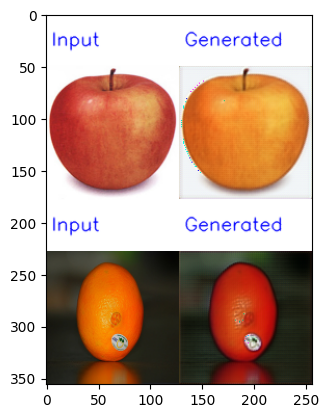

In [35]:
net_img_b, net_img_g, net_img_r = cv2.split(net_img)
net_img = cv2.merge([net_img_r, net_img_g, net_img_b])
plt.imshow(net_img)

#### Graphs for Generator and Discriminator Losses

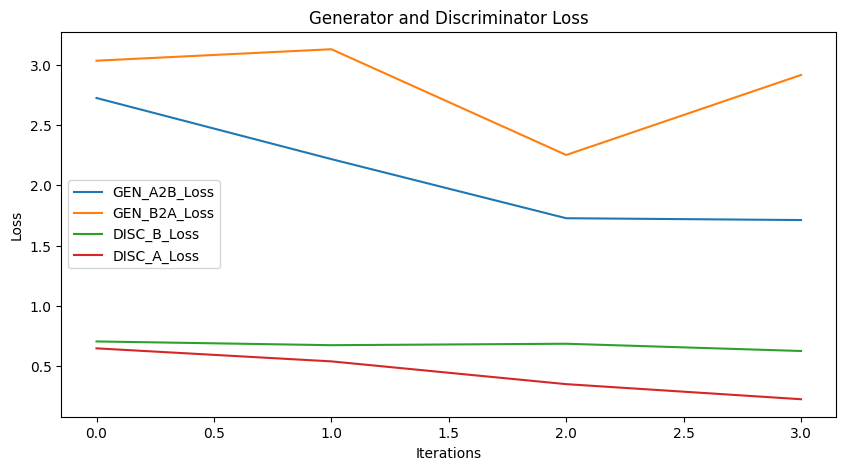

In [36]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss")
plt.plot(loss_gen_a2b,label="GEN_A2B_Loss")
plt.plot(loss_gen_b2a,label="GEN_B2A_Loss")
plt.plot(loss_disc_b,label="DISC_B_Loss")
plt.plot(loss_disc_a,label="DISC_A_Loss")
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.legend()
# plt.show()
plt.savefig('analysis.png')